# Time series forecasting using the darts library

In this notebook we will forecast the price of bitcoin using temporal fusion transformer, temporal convolution networks and the NBEATS model. Here all implementation is done using the darts library, in easy to use library which works a lot like scikit learn.

For more details, I encourage you to see the documentation - https://unit8co.github.io/darts/README.html

**Team:**
* Sameer Mahajan
* Geethika Marru
* Harsh Deokuliar



In [1]:
#importing necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel,NBEATSModel, TCNModel,Prophet, NHiTS,RNNModel,TransformerModel
from darts.metrics import mape, rmse, r2_score,mae
from darts.utils.statistics import check_seasonality, plot_acf,extract_trend_and_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

2022-04-27 17:39:57 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [3]:
#loading the bitcoin prices dataset with sentiment scores
df = pd.read_csv("final_price_dataset.csv")

In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,Date,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti
0,2018-01-01,0.043336,8.290000e+21,1.485130e+19,241601,13436.40113,78430,-2.93,62044.0,44,0.189724
1,2018-01-02,0.047594,8.290000e+21,1.644330e+19,340809,14732.45336,137730,9.74,77723.0,54,1.243548
2,2018-01-03,0.043609,8.290000e+21,1.497180e+19,395806,15068.48685,106540,2.73,79086.0,55,0.791414
3,2018-01-04,0.046728,8.290000e+21,1.613350e+19,424840,15150.04439,110970,0.15,74534.0,51,1.228296
4,2018-01-05,0.039635,8.290000e+21,1.372410e+19,342564,16929.99358,141960,11.69,76404.0,50,1.762493


Here is the data description of the attributes used.

1. Bitcoin inflation rate: The percentage of new coins issued, divided by the current supply.

2. Mining Difficulty: The current estimated number of hashes required to mine a block.

3. Hash rate: The average estimated number of hashes per second produced by the miners in the network.

4. Transaction count: Bitcoin transactions per day.

5. Vol. : Trading Volume of bitcoin

6. Change %: % change since last day

7. Total tweets: No of tweets per day related to bitcoin

8. Google trends: Google search trend score for bitcoin

9. new_senti : Newly generated sentiment scores.

In [4]:
df.info()
df['Date'] = pd.to_datetime(df["Date"])
#df.drop("Unnamed: 0",axis=1,inplace=True)
df.set_index("Date",inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                692 non-null    object 
 1   btc_inflation_rate  692 non-null    float64
 2   mining_difficulty   692 non-null    float64
 3   hash_rate           692 non-null    float64
 4   trans_count         692 non-null    int64  
 5   Price               692 non-null    float64
 6   Vol.                692 non-null    int64  
 7   Change %            692 non-null    float64
 8   total_tweets        692 non-null    float64
 9   Google_trends       692 non-null    int64  
 10  new_senti           692 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 59.6+ KB


,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti
Date,,,,,,,,,,
2018-01-01,0.043336,8.290000e+21,1.485130e+19,241601,13436.40113,78430,-2.93,62044.0,44,1.012230
2018-01-02,0.047594,8.290000e+21,1.644330e+19,340809,14732.45336,137730,9.74,77723.0,54,6.249569
2018-01-03,0.043609,8.290000e+21,1.497180e+19,395806,15068.48685,106540,2.73,79086.0,55,9.390858
2018-01-04,0.046728,8.290000e+21,1.613350e+19,424840,15150.04439,110970,0.15,74534.0,51,4.346288
2018-01-05,0.039635,8.290000e+21,1.372410e+19,342564,16929.99358,141960,11.69,76404.0,50,5.320144


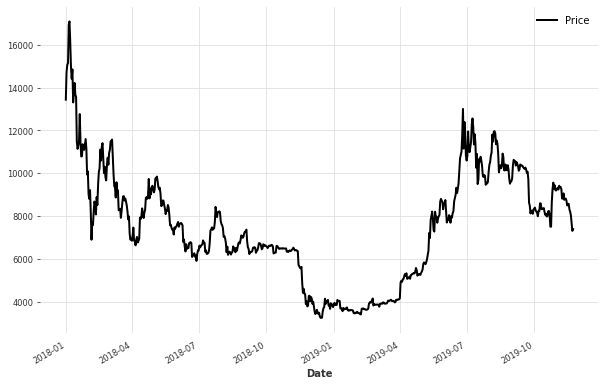

In [5]:
#Creating a timeseries object from the darts library. It will be used for the timeseries analysis for state-of-the-art models.
plt.figure(figsize=(10,6))
series = TimeSeries.from_series(df["Price"]) 
series.plot()

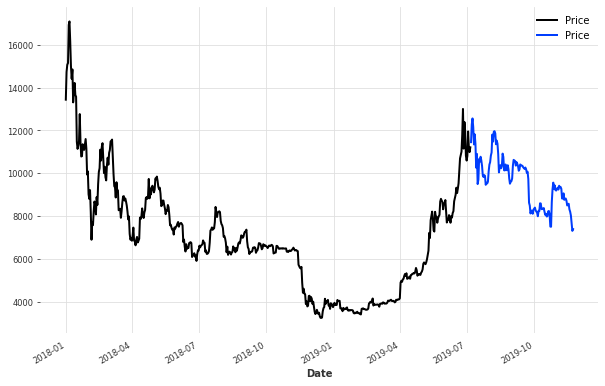

In [6]:
#creating train test split
plt.figure(figsize=(10,6))
train, test = series.split_before(0.80)
train.plot()
test.plot()

# Data Preprocessing

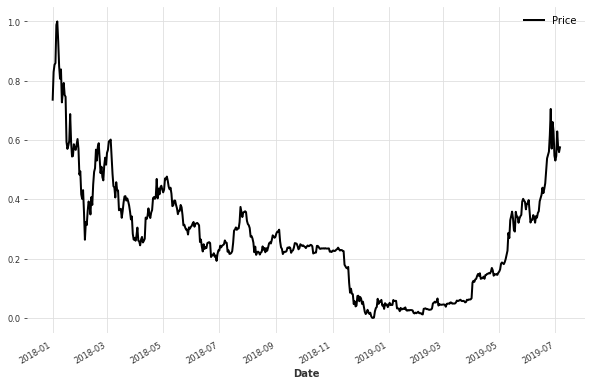

In [7]:
#using the scalar wrapper to normalize our time series data
plt.figure(figsize=(10,6))
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()

Next we will create the input tensor with all the attributes for time series analysis

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Price"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Price'], dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
#adding all the covariates (external attributes other than price) in  a timeseries object
df2 = df.drop(['Price'],axis=1)
ts_covF = TimeSeries.from_dataframe(df2)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['btc_inflation_rate', 'mining_difficulty', 'hash_rate', 'trans_count',
       'Vol.', 'Change %', 'total_tweets', 'Google_trends', 'new_senti'],
      dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [10]:
#checking shape of our model.
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(692, 9, 1)

In [11]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [12]:
# train/test split and scaling of target variable
#code contains normalized values of prices which will be fed into the model
ts_train, ts_test = ts_P.split_after(0.8)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)

#creating a scalar obejct to normalize the data
scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2018-01-01 00:00:00
training end: 2019-07-07 00:00:00
training duration: 552 days 00:00:00
test start: 2019-07-08 00:00:00
test end: 2019-11-23 00:00:00
test duration: 138 days 00:00:00
first and last row of scaled price time series:


component,Price
Date,
2018-01-01,0.74
2019-11-23,0.30


In [13]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(0.8)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t = covF_t.astype(np.float32)
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Vol.,Change %,total_tweets,Google_trends,new_senti
Date,,,,,,,,,
2018-01-01,0.61,0.00,0.02,0.34,0.00,0.41,0.50,0.40,0.00
2019-11-23,0.66,1.84,1.63,0.54,0.05,0.52,0.03,0.15,-0.00


In [14]:
#checking for seasonality. We dont have to worry about it as the model will intrinsicly learn it

In [15]:
MSEAS = 90          # max seasonality to check: days
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

In [16]:
# check for seasonality, via ACF
mseas=MSEAS
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} days'.format(mseas))

seasonal? True
There is seasonality of order 38 days


Our data seems to have a seasonliy of 38 days.

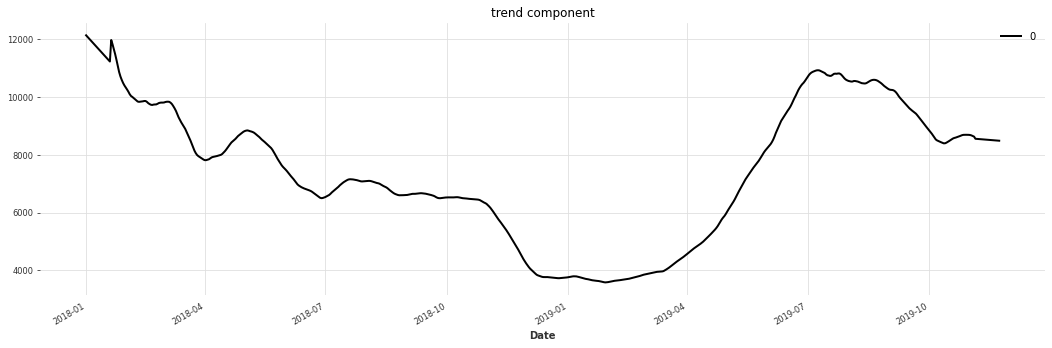

In [17]:
# ETS analysis: try to discern trend and seasonal components
# showing the trend and seasonality trends seperately
ts_trend, ts_seas = extract_trend_and_seasonality(ts=series, freq=mseas)

plt.figure(100, figsize=(18, 5))
ts_trend.plot()
plt.title("trend component");

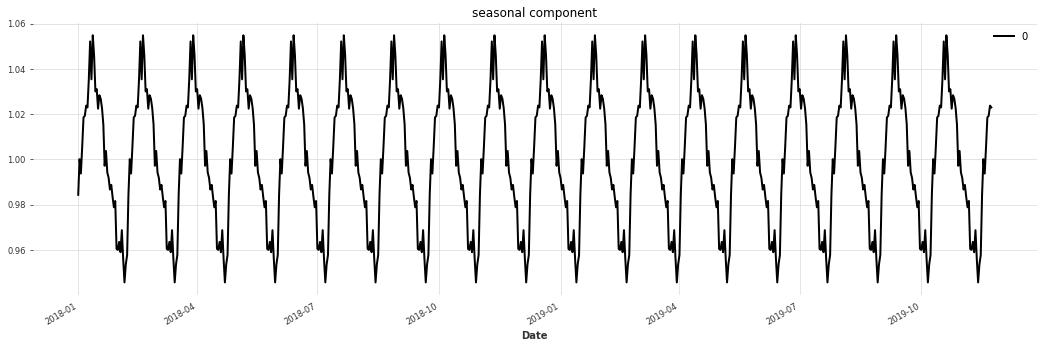

In [18]:
#seasonal component plot
plt.figure(100, figsize=(18, 5))
ts_seas.plot()
plt.title("seasonal component");

Next we have normalized all the features and now we will proceed to train and evaluate some models

# TFT MODEL

First we train the Temporal fusion transformer(TFT). We check the forecast for both the 7 days and 30 days window

In [19]:
#Using a 30 day window or lag
model = TFTModel(   input_chunk_length=30,
                    output_chunk_length=1,
                    hidden_size=64,
                    lstm_layers=2,  #LSTMLAYERS,
                    num_attention_heads=4,
                    dropout=0.1,
                    batch_size=64,
                    n_epochs=300,
                    #likelihood=QuantileRegression(quantiles=QUANTILES), 
                    random_state=42, 
                    force_reset=True,
                 torch_device_str ="cuda")

In [20]:
# training
model.fit(  ts_ttrain, 
            future_covariates=covF_ttrain,
            verbose=True)

Training: 0it [00:00, ?it/s]

Now we proceed to test our model using the historical_forecasts function below

In [21]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = model.historical_forecasts(
    ts_ttest, start=0.3, forecast_horizon=1,future_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Our model has been evaluated on the test data. Let us see the plots of the actual and predicted values.

Text(0.5, 1.0, 'TFT (window of 30 days), MAPE : 1.56%)')

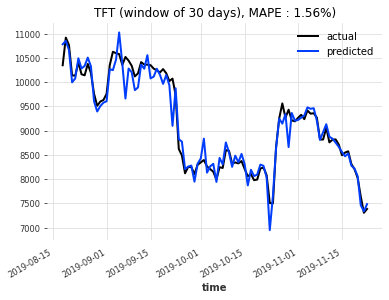

In [22]:
#plotting the actual and predicted price values

#plt.title("Naive Forecast (MAPE: {:.2f}%)".format(mape(ts_test, ts_predN)))
actual[41:].plot(label="actual")
preds.plot(label="predicted")
plt.title("TFT (window of 30 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [23]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 1.5623816289007664
rmse: 221.4348
mae: 145.29224


We get an MAPE of 1.56% on the TFT model with a sliding window of 30 days. Next we will check a sliding window of 7 days.

In [24]:
#Using a 7 day window or lag
model = TFTModel(   input_chunk_length=7,
                    output_chunk_length=1,
                    hidden_size=64,
                    lstm_layers=2,  #LSTMLAYERS,
                    num_attention_heads=4,
                    dropout=0.1,
                    batch_size=64,
                    n_epochs=300,
                    #likelihood=QuantileRegression(quantiles=QUANTILES), 
                    random_state=42, 
                    force_reset=True,
                 torch_device_str ="cuda")

In [25]:
# training
model.fit(  ts_ttrain, 
            future_covariates=covF_ttrain, 
            verbose=True)

Training: 0it [00:00, ?it/s]

In [26]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = model.historical_forecasts(
    ts_ttest, start=0.1, forecast_horizon=1,future_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Text(0.5, 1.0, 'TFT (window of 7 days), MAPE : 1.96%)')

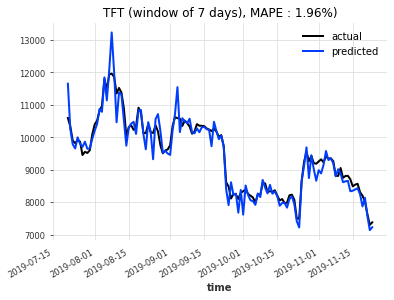

In [27]:
#plotting the actual and predicted price values
actual[13:].plot(label="actual")
preds.plot(label="predicted")
plt.title("TFT (window of 7 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [28]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 1.9618643447756767
rmse: 288.99835
mae: 188.0303


We get an MAPE of 1.96% on the TFT model with a sliding window of 7 days.

# TCN Model

We next train the Temporal convolution network (TCN) on a sliding window of 30 days and 7 days

In [29]:
from darts.models import TCNModel
#30 day window
EPOCH = 300    
FC_N = 30               # forecast periods
FC_STRIDE = 10
DROP = 0.1
LEARN = 0.001

model_TCN = TCNModel(
        input_chunk_length=30,
        output_chunk_length=1, 
        n_epochs=EPOCH,
        dropout=0.2,
        dilation_base=3,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=4,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)

In [30]:
# training: load a saved model or (re)train
# training
model_TCN.fit(  ts_ttrain, 
            past_covariates=covF_ttrain, 
            verbose=True)

Training: 0it [00:00, ?it/s]

In [31]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = model_TCN.historical_forecasts(
    ts_ttest, start=0.3, forecast_horizon=1,past_covariates=covF_t,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)


Text(0.5, 1.0, 'TCN (window of 30 days), MAPE : 2.43%)')

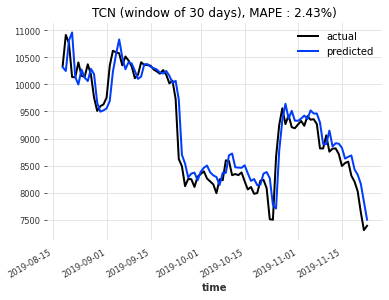

In [32]:
#plotting the actual and predicted price values
actual[41:].plot(label="actual")
preds.plot(label="predicted")
plt.title("TCN (window of 30 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [33]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 2.42711640894413
rmse: 298.4291
mae: 215.51251


The TCN model gives an MAPE of 2.43% for a 30 sliding window.Lets check the 7 day window now.

In [34]:
from darts.models import TCNModel
#30 day window
EPOCH = 300    
FC_N = 30               # forecast periods
FC_STRIDE = 10
DROP = 0.1
LEARN = 0.001

model_TCN = TCNModel(
        input_chunk_length=7,
        output_chunk_length=1, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)

In [35]:
# training: load a saved model or (re)train
# training
model_TCN.fit(  ts_ttrain, 
            past_covariates=covF_ttrain, 
            verbose=True)

Training: 0it [00:00, ?it/s]

In [36]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = model_TCN.historical_forecasts(
    ts_ttest, start=0.1, forecast_horizon=1,past_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Text(0.5, 1.0, 'TCN (window of 7 days), MAPE : 3.11%)')

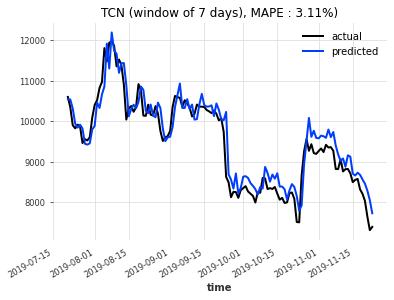

In [37]:
#plotting the actual and predicted price values
actual[13:].plot(label="actual")
preds.plot(label="predicted")
plt.title("TCN (window of 7 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [38]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 3.111855499446392
rmse: 365.04944
mae: 287.0434


The TCN model gives an MAPE of 3.11% for a 7 sliding window.

# NBEATS MODEL

Next we train the NBeats model on both the 7 and 30 day windows.

In [44]:
#NBEATSModel - 30 day window
NBEATS_model = NBEATSModel(    input_chunk_length=30,
                        output_chunk_length=1,
                        num_stacks=32,
                        layer_widths=16,
                        n_epochs=100,
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=42,
                        force_reset=True,
                        save_checkpoints=True,
                        torch_device_str="cuda"
                    )

Lets train the model

In [45]:
# training: load a saved model or (re)train
NBEATS_model.fit(  series=ts_ttrain, 
            past_covariates=covF_ttrain,
                verbose=True)

Training: 0it [00:00, ?it/s]

Now that the model has been trained lets test the forecast on the test data.

In [46]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = NBEATS_model.historical_forecasts(
    ts_ttest, start=0.3, forecast_horizon=1,past_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Text(0.5, 1.0, 'N-BEATS (window of 30 days), MAPE : 14.45%)')

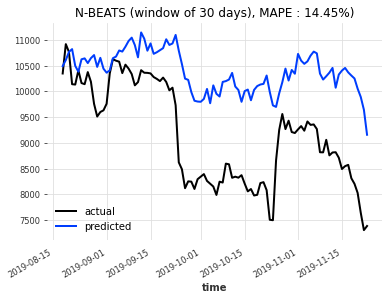

In [47]:
#plotting the actual and predicted price values
actual[41:].plot(label="actual")
preds.plot(label="predicted")
plt.title("N-BEATS (window of 30 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [48]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 14.445382356643677
rmse: 1408.7769
mae: 1241.7488


We get a MAPE of 14.45% which isnt great.Lets check the performance for the 7-day window.

In [51]:
#NBEATSModel - 7 day window
NBEATS_model = NBEATSModel(    input_chunk_length=7,
                        output_chunk_length=1, 
                        num_stacks=32,
                        layer_widths=16,
                        n_epochs=100,
                        nr_epochs_val_period=1,  
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=42,
                        force_reset=True,
                        save_checkpoints=True,
                        torch_device_str="cuda"
                    )

In [52]:
# training: load a saved model or (re)train
NBEATS_model.fit(  series=ts_ttrain, 
            past_covariates=covF_ttrain,
                verbose=True)

Training: 0it [00:00, ?it/s]

In [53]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = NBEATS_model.historical_forecasts(
    ts_ttest, start=0.3, forecast_horizon=1,past_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Text(0.5, 1.0, 'N-BEATS (window of 7 days), MAPE : 3.14%)')

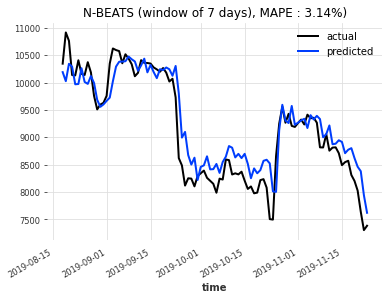

In [54]:
#plotting the actual and predicted price values
actual[41:].plot(label="actual")
preds.plot(label="predicted")
plt.title("N-BEATS (window of 7 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

In [55]:
#metrics of time series forecast
print("MAPE:",mape(actual,preds))
print("rmse:", rmse(actual,preds))
print("mae:",mae(actual,preds))

MAPE: 3.14338319003582
rmse: 364.63235
mae: 274.1947


The 7-day window has a MAPE of 3.14% which is much better compared to the 30-day window.

# GridSearch

Below we find the optimal TCN model with grid search

In [104]:
parameters = {
    "input_chunk_length" : [7,30,60],
    "output_chunk_length" : [1], 
    "dilation_base" : [2,3,4],
    "kernel_size" : [3,4,5],
    "num_filters" : [2,3,4],
    "dropout" : [0.1,0.2],
    "torch_device_str" : ["cuda"]
    
}

best_model = model_TCN.gridsearch(parameters=parameters,series=ts_ttrain,val_series=ts_ttest,past_covariates=covF_t,metric=mape,reduction=np.mean)

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

In [105]:
best_model

(<darts.models.forecasting.tcn_model.TCNModel at 0x171d467bcc8>,
 {'input_chunk_length': 30,
  'output_chunk_length': 1,
  'dilation_base': 3,
  'kernel_size': 5,
  'num_filters': 4,
  'dropout': 0.1,
  'torch_device_str': 'cuda'},
 14.766673743724823)

The best model has a window of 30 days , dilation base of 3 , kernel size of 5 , 4 filters and a dropout of 0.1. Lets next train a TCN model with these paramters and evalutate its metrics.

Grid search for the NBEATS model is performed below.

In [64]:
parameters = {
    "input_chunk_length" : [7,30,60],
    "output_chunk_length" : [1,7], 
    "num_stacks" : [16,32,64],
    "num_blocks" : [1,2,3],
    "num_layers" : [4],
    "layer_widths" : [16,32,64,128,256],
    "torch_device_str" : ["cuda"]    
}

best_model = NBEATSModel.gridsearch(parameters=parameters,series=ts_ttrain,val_series=ts_ttest,past_covariates=covF_t,metric=mape,reduction=np.mean)

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

In [66]:
best_model

(<darts.models.forecasting.nbeats.NBEATSModel at 0x17187c48a48>,
 {'input_chunk_length': 7,
  'output_chunk_length': 1,
  'num_stacks': 32,
  'num_blocks': 1,
  'num_layers': 4,
  'layer_widths': 16,
  'torch_device_str': 'cuda'},
 26.609021425247192)

the best NBEATS-model has the above parameters. This model has already been trained and hence we will not train it.

In [107]:
#retraining the TCN model with optimal parameters

model_TCN_grid_search = TCNModel(
        input_chunk_length=30,
        output_chunk_length=1, 
        n_epochs=300,
        dropout=0.1,
        dilation_base=3,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=4,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)

In [108]:
# training: load a saved model or (re)train
# training
model_TCN_grid_search.fit(  ts_ttrain, 
            past_covariates=covF_ttrain, 
            verbose=True)

Training: 0it [00:00, ?it/s]

In [109]:
%%capture
#Testing our model using historical_forecasts on ts_ttest 
preds = model_TCN_grid_search.historical_forecasts(
    ts_ttest, start=0.3, forecast_horizon=1,past_covariates=covF_ttest,retrain=False
)

# scale back:
preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(ts_ttest)

Text(0.5, 1.0, 'N-BEATS (window of 7 days), MAPE : 5.41%)')

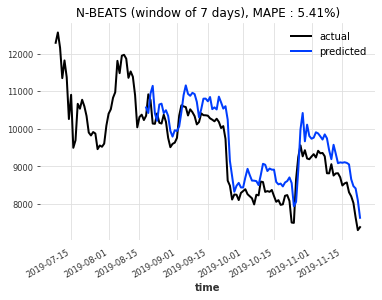

In [110]:
#plotting the actual and predicted price values
actual.plot(label="actual")
preds.plot(label="predicted")
plt.title("N-BEATS (window of 7 days), MAPE : {:.2f}%)".format(mape(actual,preds)))

### Issues / Improvements
1. A more rigerous grid search for time series forecasting of these models

#Credits

1. https://unit8co.github.io/darts/README.html
2. https://towardsdatascience.com/n-beats-unleashed-deep-forecasting-using-neural-basis-expansion-analysis-in-python-343dd6307010

In summary the state-of-the-art models do a good job of forecasting the price of bitcoin.